## 抓取高鐵驗證碼

In [1]:
! mkdir data

In [4]:
import requests
from bs4 import BeautifulSoup

headers = {
  'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36'  
}

def getCaptcha(i):
    rs = requests.session()
    res = rs.get('https://irs.thsrc.com.tw/IMINT/', headers = headers)
    soup = BeautifulSoup(res.text, 'lxml')
    domain = 'https://irs.thsrc.com.tw'
    imgsrc = soup.select_one('img#BookingS1Form_homeCaptcha_passCode').get('src')
    imgurl = domain + imgsrc
    res2 = rs.get(imgurl, headers = headers)
    with open('data/{}.jpg'.format(i), 'wb') as f:
        f.write(res2.content)

In [6]:
#getCaptcha(1)

## 載入驗證碼圖片

In [7]:
! wget https://raw.githubusercontent.com/ywchiu/fubondl/main/data/captcha_jpg.zip

--2021-01-15 06:23:05--  https://raw.githubusercontent.com/ywchiu/fubondl/main/data/captcha_jpg.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3818150 (3.6M) [application/zip]
Saving to: ‘captcha_jpg.zip’

captcha_jpg.zip     100%[===================>]   3.64M  --.-KB/s    in 0.1s    

2021-01-15 06:23:06 (34.0 MB/s) - ‘captcha_jpg.zip’ saved [3818150/3818150]



In [8]:
! unzip captcha_jpg.zip > 1.log

In [11]:
! ls data/ | wc -l

999


In [18]:
from PIL import Image
img = Image.open('data/1.jpg')
img.size

(135, 47)

In [12]:
import pandas
df = pandas.read_csv('https://raw.githubusercontent.com/ywchiu/fubondl/main/data/output_captua.csv', index_col = 0)

In [15]:
df.dropna(inplace=True)
df['file'] = df['file'].map(lambda e: 'data/{}.jpg'.format(int(e)) )

In [16]:
df.head()

,captcua,file
0.0,4ay2,data/1.jpg
2.0,qmqh,data/2.jpg
4.0,kc3c,data/3.jpg
6.0,1549,data/4.jpg
8.0,5rqz,data/5.jpg


In [17]:
len(df)

998

## 建立 CNN 模型

In [19]:
characters = '0123456789abcdefghijklmnopqrstuvwxyz'
# Captcha生成圖像的寬高、用幾個字母來組成字串及會用到的字母數
width, height, n_len, n_class = 135, 47, 4, 36

In [90]:
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense

input_tensor = Input((height, width, 3))

x = input_tensor

#  模仿 VGG  架構模型
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x) 

x = Conv2D(256, (3, 3), activation='relu')(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x) 

x = Flatten()(x)
x = Dropout(0.25)(x)

x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]

model = Model(inputs=input_tensor, outputs=x)

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 47, 135, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 45, 133, 64)  1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 43, 131, 64)  36928       conv2d_12[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 21, 65, 64)   0           conv2d_13[0][0]                  
____________________________________________________________________________________________

## 訓練模型

In [26]:
import os 
os.mkdir('trainset')

In [28]:
import numpy as np
X = np.zeros((len(df), height, width, 3), dtype=np.float32)
y = [np.zeros((len(df), n_class), dtype=np.uint8) for i in range(n_len)]

In [29]:
X.shape

(998, 47, 135, 3)

In [32]:
len(y)
y[0].shape

(998, 36)

In [38]:
df.reset_index(drop = 'index', inplace=True)

In [39]:
for i in df.index:
    random_str = df.loc[i,'captcua']
    fname = df.loc[i,'file']
    f1 = Image.open(fname)
    f1 = f1.resize((width, height))
    f = np.array(f1)
    #print(f.shape)
    #f.resize(height,width)
    #print(f)
    X[i] = f * 1.0 / 255.0
    for j, ch in enumerate(random_str):
        y[j][i, :] = 0
        y[j][i, characters.find(ch)] = 1

In [41]:
X[0].shape

(47, 135, 3)

In [43]:
y[0][0]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [48]:
import random
def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.float32)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    while True:
        
        for i in range(batch_size):
            rand_index = random.choice(df.index)
            random_str = df.loc[rand_index,'captcua']
            fname = df.loc[rand_index,'file']
            f1 = Image.open(fname)
            f1 = f1.resize((width, height))
            f = np.array(f1)
            X[i] = f / 255.0
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

In [50]:
for x,y in gen(batch_size = 32):
  print(x.shape)
  print(len(y))
  break

(32, 47, 135, 3)
4


In [ ]:
from tensorflow.keras import callbacks
cbks = [callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)]

history = model.fit_generator(gen(batch_size=32),      # 每次生成器會產生32筆小批量的資料
                    epochs=20,                          # 總共跑20個訓練循環
                    steps_per_epoch=1000,     # 每個epoch 產生1000 組batch
                    #callbacks=cbks,          # 保存最好的模型到檔案
                    validation_data=gen(),   # 驗證資料也是用生成器來產生
                    validation_steps=40      # 用40組資料來驗證
                   )

## 測試模型

In [78]:
img = Image.open('data/567.jpg')

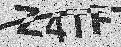

In [89]:
img

In [79]:
img.size

(121, 47)

In [80]:
width

135

In [81]:
X1 = np.array(img.resize((width, height)))
X1 = X1 * 1.0 / 255.0

In [82]:
X1.shape

(47, 135, 3)

In [83]:
X1 = X1.reshape((1, height, width, 3))

In [84]:
X1.shape

(1, 47, 135, 3)

In [86]:
[np.argmax(e) for e in model.predict(X1)]

[35, 4, 29, 15]

In [88]:
characters = '0123456789abcdefghijklmnopqrstuvwxyz'
[characters[np.argmax(e)] for e in model.predict(X1)]

['z', '4', 't', 'f']